In [317]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal,Annotated,operator
from langchain_groq import ChatGroq
from langchain.messages import HumanMessage,SystemMessage
from dotenv import load_dotenv
from pydantic import BaseModel,Field

In [318]:
load_dotenv()

True

In [319]:
llm_writer=ChatGroq(model="llama-3.1-8b-instant")

In [320]:
llm_eval=ChatGroq(model="openai/gpt-oss-120b")
llm_optimizer=ChatGroq(model="openai/gpt-oss-120b")

In [321]:
class EVAL(BaseModel):
    status: Literal["approved", "needs_improvement"] = Field(
        ..., 
        description="Final evaluation whether the post is approved or not"
    )
    feedback: str = Field(..., description="feedback for the post")

In [322]:
model_eval=llm_eval.with_structured_output(EVAL)

In [323]:
class TweetState(TypedDict):
    topic: str
    tweet: str
    status: Literal["approved", "needs_improvement"] 
    feedback: str
    iter: int
    max_iter: int

    posts:Annotated[list[str],operator.add]
    past_feedbacks:Annotated[list[str],operator.add]

In [324]:
graph=StateGraph(TweetState)

In [325]:
def gen_tweet(state:TweetState)->dict:
    messages:list=[
        SystemMessage(content="You are a funny and clever twitter/x influencer"),
        HumanMessage(content=f"""
        Write a short,original, X post on the topic:"{state["topic"]}".
        Rules:
        1.Do not use question answer format
        2.MAX_CHAR LIMIT=280
        3.use humor,sarcasm,cultural refrences
        4.use meme refrences
        5.use simple day to day english
        -This version is {state["iter"]+1}.
""")
    ]
    res=llm_writer.invoke(messages).content
    return {"tweet":res,"posts":[res]}

In [326]:
def eval_tweet(state: TweetState) -> dict:
    messages = [
        SystemMessage(content="""
You are a ruthless, no-laugh-given Twitter critic.
You evaluate tweets based on originality, humor, punchiness, virality, and format.
You are brutally honest and concise.
"""),
        
        HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below:

1. Originality: Is it fresh or overused?
2. Humor: Does it genuinely make you smile or laugh?
3. Punchiness: Is it short, sharp, and scroll-stopping?
4. Virality Potential: Would people retweet it?
5. Format: Is it a proper standalone tweet (not Q&A, not setup punchline, under 280 chars)?

Auto-reject if:
- It's in question-answer format
- It exceeds 280 characters
- It reads like a traditional setup punchline joke
- It ends with vague, deflating, or generic lines

Respond ONLY in this structured format:

status: "approved" or "needs_improvement"
feedback: One paragraph explaining strengths and weaknesses
""")
    ]
    
    # We invoke the model which is now bound to the updated EVAL class
    res = model_eval.invoke(messages)
    
    # Return 'status' instead of 'eval'
    return {"feedback": res.feedback, "status": res.status,"past_feedbacks":[res.feedback]}

In [327]:
def optim_tweet(state:TweetState)->dict:
    messages = [
    SystemMessage(content="""
You are a ruthless Twitter punch-up editor.
Your job is to rewrite tweets to maximize humor, originality, punchiness, and virality.
You remove fluff, avoid generic endings, and never use Q&A or setup–punchline formats.
"""),
    
    HumanMessage(content=f"""
Improve the tweet using the feedback below.

Feedback:
"{state['feedback']}"

Topic:
"{state['topic']}"

Original Tweet:
"{state['tweet']}"

Rewrite it as a single, sharp, viral-worthy tweet.
Rules:
- Under 280 characters
- Not a question
- Not Q&A
- Not a traditional joke setup
- No generic or deflating endings
Return ONLY the improved tweet.
""")
]
    res=llm_optimizer.invoke(messages).content
    iter=state['iter']+1
    return{"tweet":res,"iter":iter,"post":[res]}

In [328]:
graph.add_node("gen_tweet",gen_tweet)
graph.add_node("optim_tweet",optim_tweet)
graph.add_node("eval_tweet",eval_tweet)

In [329]:
def route_eval(state: TweetState):
    if state['status'] == 'approved' or state['iter'] >= state['max_iter']:
        return "approved"
    else:
        return "needs_improvement"

In [330]:
graph.add_edge(START,"gen_tweet")
graph.add_edge("gen_tweet","eval_tweet")

graph.add_conditional_edges("eval_tweet",route_eval,{"approved":END,"needs_improvement":"optim_tweet"})
graph.add_edge("optim_tweet","eval_tweet")

In [331]:
workflow=graph.compile()

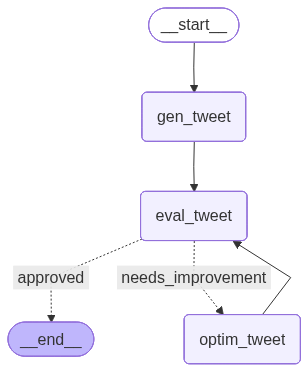

In [332]:
workflow

In [333]:
workflow.invoke({
    "topic":"AI can code like humans",
    "iter":1,
    "max_iter":5
})

{'topic': 'AI can code like humans',
 'tweet': 'AI turned my IDE into a psychic sidekick: it writes the function, the docs, the commit message, and even my Tinder bio. My code was my superpower—now it’s just a co‑pilot. #AICode',
 'status': 'approved',
 'feedback': 'The tweet is a solid standalone post under the character limit, with a clear hook and a relatable #AICode tag. It mixes a fresh angle (Tinder bio) into the over‑used AI‑assistant trope, giving it modest originality. The humor lands as a light smile rather than a punchline, and the sentence is a bit wordy, hurting its scroll‑stopping punchiness. Still, it’s likely to resonate with devs and AI‑enthusiasts, giving it decent retweet potential. Tightening the phrasing would boost impact, but it passes the basic criteria.',
 'iter': 2,
 'max_iter': 5,
 'posts': ['"Just when you thought coding was your superpower, AI goes and steals the show. Now it\'s like, \'Hey, human, I\'ll just write this code for you... and also the novel yo